# Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base64

In [16]:
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import FieldOfViewOVCs
# from ratinabox.Neurons import PlaceCells, GridCells #...

## aux funcs

In [17]:
import random
import string

def generate_random_string(n):
    """
    Generate a random string of length n.

    Parameters:
    n (int): The desired length of the string.

    Returns:
    str: A random string of length n.
    """
    if n <= 0:
        raise ValueError("Length 'n' must be a positive integer.")

    # Combine letters, digits, and punctuation
    characters = string.ascii_uppercase
    
    # Generate a random string of length n
    random_string = ''.join(random.choices(characters, k=n))

    return random_string


In [18]:
generate_random_string(8)

'TCEMLRUT'

In [19]:
def get_rand_letter(x):
    if x <= 0.2:
        return 'A'
    elif x > 0.2 and x <= 0.4:
        return 'B'
    elif x > 0.4 and x <= 0.6:
        return 'C'
    elif x > 0.6 and x <= 0.8:
        return 'D'
    else:
        return 'E'

In [20]:
def is_point_in_hole(point, hole):
    """
    Verifica se um ponto está dentro de um polígono (hole).
    """
    x, y = point
    n = len(hole)
    inside = False

    px, py = hole[0]
    for i in range(1, n + 1):
        cx, cy = hole[i % n]
        if y > min(py, cy):
            if y <= max(py, cy):
                if x <= max(px, cx):
                    if py != cy:
                        xinters = (y - py) * (cx - px) / (cy - py) + px
                        if px == cx or x <= xinters:
                            inside = not inside
        px, py = cx, cy

    return inside

In [21]:
def is_point_valid(point, hole):
    x_valid = True
    y_valid = True
    point_valid = True
    hole_x_inf = hole[0][0]
    hole_x_sup = hole[1][0]
    hole_y_inf = hole[0][1]
    hole_y_sup = hole[1][1]
    # check x pos
    if (point[0] > hole_x_inf) and (point[0] < hole_x_sup):
        x_valid = False
    if (point[1] > hole_y_inf) and (point[1] < hole_y_sup):
        y_valid = False
    if (not x_valid or  not y_valid) or (not x_valid and y_valid):
        point_valid = False
    # print(point, point_valid, x_valid, y_valid)
    return point_valid


In [22]:
def generate_all_positions_on_env(hole):
        # Define the range and step size
    step = 0.01  # Adjust the step size for granularity
    x_range = np.arange(0, 1 + step, step)
    y_range = np.arange(0, 1 + step, step)

    # Create a grid of (x, y) positions
    x, y = np.meshgrid(x_range, y_range)
    positions = np.column_stack([x.ravel(), y.ravel()])

    # Convert to a pandas DataFrame
    df_positions = pd.DataFrame(positions, columns=["X", "Y"])
    df_positions['is_valid'] = [int(is_point_valid(pos, hole)) for pos in positions]
    df_positions['pos'] = [val for val in positions]

    return df_positions

In [23]:
def get_euclidean_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + ((pos1[1] - pos2[1])**2))
def apply_eucd_dist(x, obj=9):
    return get_euclidean_distance(x['pos'], x[f'obj_{obj}_pos'])

In [24]:
np.random.rand(3, 1)

array([[0.8145735 ],
       [0.94788786],
       [0.73112985]])

In [25]:
hole_deff = [[0.4,0.2],[0.6,0.2],[0.6,0.8],[0.4,0.8]]

In [26]:
generate_all_positions_on_env(hole_deff)['is_valid'].mean()

0.8118811881188119

In [27]:
hole_deff[1][0]

0.6

## Define EnV

In [28]:
Env = Environment(params={
    'aspect':1,
    'holes' : [[[0.4,0.2],[0.6,0.2],[0.6,0.8],[0.4,0.8]]],
    })

### Num of Cues

In [29]:
NUM_OF_CUES = 100

### RUN PARAMETERS

In [30]:
CUE_NAME_LEN = 4

MAX_NUMBER_OF_CUES = 7
CONTEXT_LEN = MAX_NUMBER_OF_CUES*CUE_NAME_LEN
CONTEXT_LEN

28

### gerando cues positions

In [31]:
CUES_LIST = []
num_test = 0
for i in range(NUM_OF_CUES):
    candidate_point = 0.45, 0.55
    while not is_point_valid(candidate_point, hole_deff):
        candidate_point = np.random.rand(), np.random.rand()
        num_test+=1
    CUES_LIST.append(candidate_point)
print(f'{NUM_OF_CUES} cues criadas com {num_test} candidatos')

100 cues criadas com 129 candidatos


### gerando all positions df

In [32]:
ap = generate_all_positions_on_env(hole=hole_deff)
ap.head()

,X,Y,is_valid,pos
0,0.00,0.0,1,"[0.0, 0.0]"
1,0.01,0.0,1,"[0.01, 0.0]"
2,0.02,0.0,1,"[0.02, 0.0]"
3,0.03,0.0,1,"[0.03, 0.0]"
4,0.04,0.0,1,"[0.04, 0.0]"


### adicionando cues ao EnV

In [33]:
for point in CUES_LIST:
    Env.add_object(object=point,type=0)

In [34]:
len(Env.objects['objects']), NUM_OF_CUES

(100, 100)

### adding name to cue

In [35]:
objects_name_list = []
for i in range(NUM_OF_CUES):
    obj_name = generate_random_string(CUE_NAME_LEN)
    if obj_name in objects_name_list:
        obj_name = generate_random_string(CUE_NAME_LEN)
    objects_name_list.append(obj_name)

In [36]:
len(objects_name_list), len(set(objects_name_list))

(100, 100)

In [37]:
# # objetos a direita do buraco
# Env.add_object(object=[0.9,0.3],type=0)
# Env.add_object(object=[0.7,0.1],type=0)
# Env.add_object(object=[0.7,0.5],type=0)
# Env.add_object(object=[0.9,0.7],type=0)
# Env.add_object(object=[0.7,0.9],type=0)


# # objetos a esquerda do buraco
# Env.add_object(object=[0.3,0.3],type=0)
# Env.add_object(object=[0.1,0.1],type=0)
# Env.add_object(object=[0.1,0.5],type=0)
# Env.add_object(object=[0.3,0.7],type=0)
# Env.add_object(object=[0.1,0.9],type=0)

In [38]:
objects_name_list[:3]

['FIZB', 'HVFD', 'OMBI']

In [39]:
Env.objects['object_names'] = objects_name_list

In [40]:
# Env.objects

### add encode to obj

In [ ]:
OBJ_ENCODE_DIM = 3

In [42]:
np.matmul(np.random.rand(1, 3), np.random.rand(3, 1))

array([[0.89821708]])

In [46]:
objects_encode_list = []
for i in range(NUM_OF_CUES):
    obj_enc = np.random.rand(3, 1)
    # if obj_enc in objects_encode_list:
        # obj_enc = np.random.rand(3, 1)
    objects_encode_list.append(obj_enc)

In [47]:
Env.objects['object_encs'] = objects_encode_list

## vizz env

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


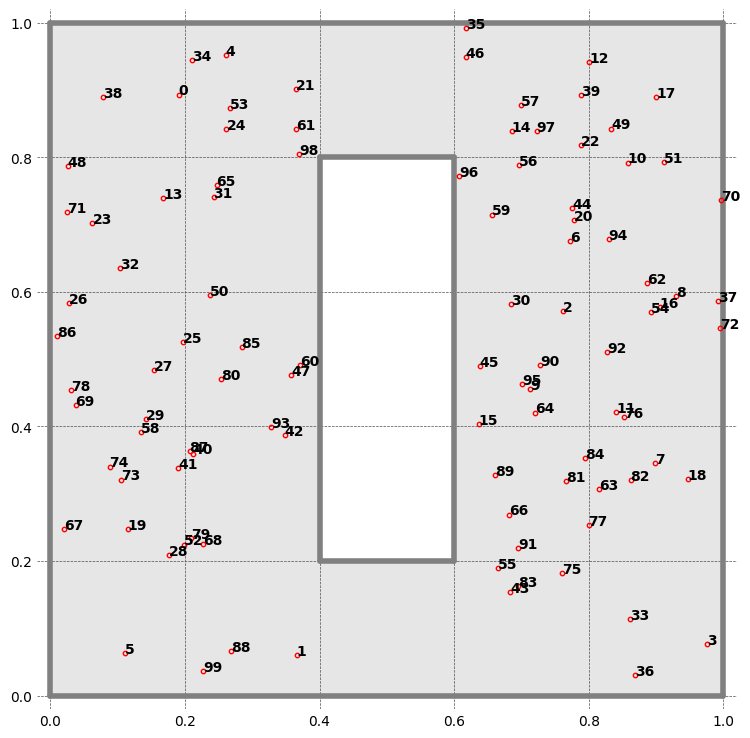

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
for i in range(NUM_OF_CUES):
    plt.annotate(text=i, xy=Env.objects['objects'][i],fontweight='bold', fontsize=10)
Env.plot_environment(gridlines=True, fig=fig, ax=ax) #visualises current environment with walls and objects
# Agent.plot_trajectory() #plots trajectory
# Agent.animate_trajectory() #animate trajectory
# Neurons.plot_rate_map() # plots the rate map of the neurons at all positions
# Neurons.plot_rate_timeseries() # plots activities of the neurons over time 
# Neurons.animate_rate_timeseries() # animates the activity of the neurons over time 
plt.show()

In [49]:
Ag = Agent(Env)

# agent configs
# Ag.pos = start_pos
Ag.thigmotaxis = 0.2

In [25]:
# default_params = {
#         "distance_range": [0.02, 0.4],  # min and max distances the agent can "see"
#         "angle_range": [0,75],  # angluar FoV in degrees (will be symmetric on both sides, so give range in 0 (forwards) to 180 (backwards)
#         "spatial_resolution": 0.02,  # resolution of each BVC tiling FoV
#         "beta": 5, # smaller means larger rate of increase of cell size with radius in hartley type manifolds
#         "cell_arrangement": "diverging_manifold",  # whether all cells have "uniform" receptive field sizes or they grow ("hartley") with radius.
#         "object_tuning_type" : None, #can be "random", any integer, or a list of integers of length n. The tuning types of the OVCs.
#     }

In [26]:
# new_params = {
#         "distance_range": [0.001, 1],  # min and max distances the agent can "see"
#         "angle_range": [0,180],  # angluar FoV in degrees (will be symmetric on both sides, so give range in 0 (forwards) to 180 (backwards)
#         "spatial_resolution": 0.02,  # resolution of each BVC tiling FoV
#         "beta": 5, # smaller means larger rate of increase of cell size with radius in hartley type manifolds
#         "cell_arrangement": "diverging_manifold",  # whether all cells have "uniform" receptive field sizes or they grow ("hartley") with radius.
#         "object_tuning_type" : 0, #can be "random", any integer, or a list of integers of length n. The tuning types of the OVCs.
#     }

In [27]:
# FoV_OVCs = FieldOfViewOVCs(Ag,new_params)

In [50]:
for i in range(int(15*60/Ag.dt)):
    Ag.update()
    # FoV_OVCs.update()

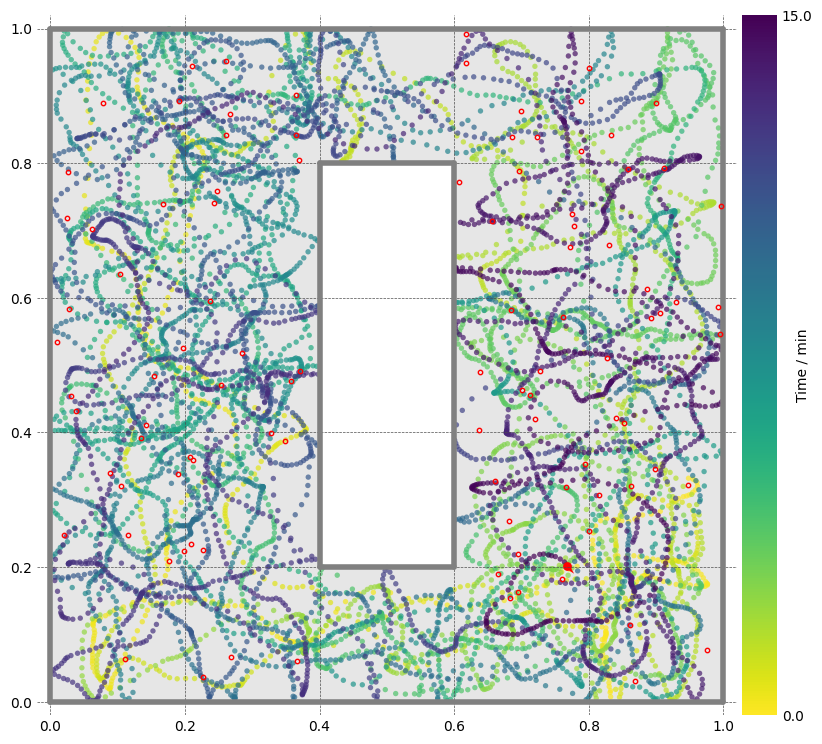

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax = Ag.plot_trajectory(color='changing', colorbar=True, gridlines=True,fig=fig, ax=ax)
plt.show()

# init dfbase

In [52]:
dfbase = pd.DataFrame(Ag.history).copy()
print(dfbase.shape)
dfbase.head(2)

(18000, 6)


,t,pos,distance_travelled,vel,rot_vel,head_direction
0,0.05,"[0.9481359873429684, 0.33197961175786933]",0.002769,"[0.05478942838579304, -0.008028506825109583]",-2.588245,"[0.998248480520846, -0.05916055390056853]"
1,0.10,"[0.9517629390211633, 0.33129166678541744]",0.006460,"[0.07253903356389646, -0.013758899449037854]",-0.839015,"[0.9948106166211471, -0.10174397799306394]"


In [57]:
# df = dfbase.iloc[:150].copy() #dfbase[dfbase.index%10 == 0].copy()
df = dfbase.copy()
df.shape

(18000, 6)

In [58]:
# Env.objects

In [59]:
# fixed_object = 8
# Env.objects['objects'][fixed_object]

In [60]:
# Env.objects

## adding obj pos and names to dfbase

In [61]:
for i in range(NUM_OF_CUES):
    cue_dict = {f'obj_{i}_pos':[Env.objects['objects'][i] for _ in df.index],
         f'obj_{i}_name':[Env.objects['object_names'][i] for _ in df.index],
         f'obj_{i}_enc':[Env.objects['object_encs'][i] for _ in df.index]}
    cue_df = pd.DataFrame(data=cue_dict, index=df.index)  
    df = pd.concat([df, cue_df], axis=1)
    # df[f'obj_{i}_pos'] = [Env.objects['objects'][i] for _ in df.index]
    # df[f'obj_{i}_name'] = [Env.objects['object_names'][i] for _ in df.index]

In [62]:
for i in range(NUM_OF_CUES):
    cue_dict = {f'obj_{i}_pos':[Env.objects['objects'][i] for _ in ap.index],
         f'obj_{i}_name':[Env.objects['object_names'][i] for _ in ap.index]}
    cue_ap = pd.DataFrame(data=cue_dict, index=ap.index)  
    ap = pd.concat([ap, cue_ap], axis=1)
    # df[f'obj_{i}_pos'] = [Env.objects['objects'][i] for _ in df.index]
    # df[f'obj_{i}_name'] = [Env.objects['object_names'][i] for _ in df.index]

In [63]:
df.shape

(18000, 306)

In [64]:
df.head(2)

,t,pos,distance_travelled,vel,rot_vel,head_direction,obj_0_pos,obj_0_name,obj_0_enc,obj_1_pos,...,obj_96_enc,obj_97_pos,obj_97_name,obj_97_enc,obj_98_pos,obj_98_name,obj_98_enc,obj_99_pos,obj_99_name,obj_99_enc
0,0.05,"[0.9481359873429684, 0.33197961175786933]",0.002769,"[0.05478942838579304, -0.008028506825109583]",-2.588245,"[0.998248480520846, -0.05916055390056853]","[0.19061501152391858, 0.8929896169270976]",FIZB,"[[0.5700049322169386], [0.7009784407054439], [...","[0.36593238993110766, 0.0597703141757594]",...,"[[0.3622954646192309], [0.3316008654059788], [...","[0.722668943603895, 0.8390507069258969]",XTYH,"[[0.9806964906238709], [0.23511796457097578], ...","[0.36948443631688566, 0.8048250212548951]",GLFL,"[[0.2998260952472038], [0.30436637636950814], ...","[0.22661237008675772, 0.03684283762913931]",MDRZ,"[[0.7261037072723464], [0.6016941431077041], [..."
1,0.10,"[0.9517629390211633, 0.33129166678541744]",0.006460,"[0.07253903356389646, -0.013758899449037854]",-0.839015,"[0.9948106166211471, -0.10174397799306394]","[0.19061501152391858, 0.8929896169270976]",FIZB,"[[0.5700049322169386], [0.7009784407054439], [...","[0.36593238993110766, 0.0597703141757594]",...,"[[0.3622954646192309], [0.3316008654059788], [...","[0.722668943603895, 0.8390507069258969]",XTYH,"[[0.9806964906238709], [0.23511796457097578], ...","[0.36948443631688566, 0.8048250212548951]",GLFL,"[[0.2998260952472038], [0.30436637636950814], ...","[0.22661237008675772, 0.03684283762913931]",MDRZ,"[[0.7261037072723464], [0.6016941431077041], [..."


## measure distances to objs

In [65]:
for i in range(NUM_OF_CUES):
    dist_cue_dict = {f'dist_to_obj_{i}': df.apply(apply_eucd_dist, axis=1, obj=i)}
    dist_cue_df = pd.DataFrame(data=dist_cue_dict, index=df.index)
    df = pd.concat([df, dist_cue_df], axis=1)

In [66]:
for i in range(NUM_OF_CUES):
    dist_cue_dict = {f'dist_to_obj_{i}': ap.apply(apply_eucd_dist, axis=1, obj=i)}
    dist_cue_ap = pd.DataFrame(data=dist_cue_dict, index=ap.index)
    ap = pd.concat([ap, dist_cue_ap], axis=1)

In [67]:
f"{100*len(df)} iteracoes"

'1800000 iteracoes'

In [68]:
df.shape

(18000, 406)

In [41]:
df.tail(2)

,t,pos,distance_travelled,vel,rot_vel,head_direction,obj_0_pos,obj_0_name,obj_1_pos,obj_1_name,...,dist_to_obj_90,dist_to_obj_91,dist_to_obj_92,dist_to_obj_93,dist_to_obj_94,dist_to_obj_95,dist_to_obj_96,dist_to_obj_97,dist_to_obj_98,dist_to_obj_99
17998,899.95,"[0.09956715335140742, 0.8452826209647822]",86.642807,"[0.027662243012138155, -0.08809384519040009]",1.948558,"[0.3210211949551366, -0.9470720101394488]","[0.6684926646805568, 0.2307395487112498]",LXVJ,"[0.7658613141747251, 0.7528009517926837]",KDSE,...,0.883925,0.537158,1.143842,0.805367,1.122799,0.285178,0.959703,0.845128,0.895072,0.677518
17999,900.00,"[0.10081985020637406, 0.8398746999132857]",86.648358,"[0.025053937099332735, -0.10815842102993134]",-1.532678,"[0.28955247906139464, -0.9571621398015075]","[0.6684926646805568, 0.2307395487112498]",LXVJ,"[0.7658613141747251, 0.7528009517926837]",KDSE,...,0.879757,0.535055,1.139488,0.804474,1.117966,0.284650,0.955300,0.840835,0.889944,0.672128


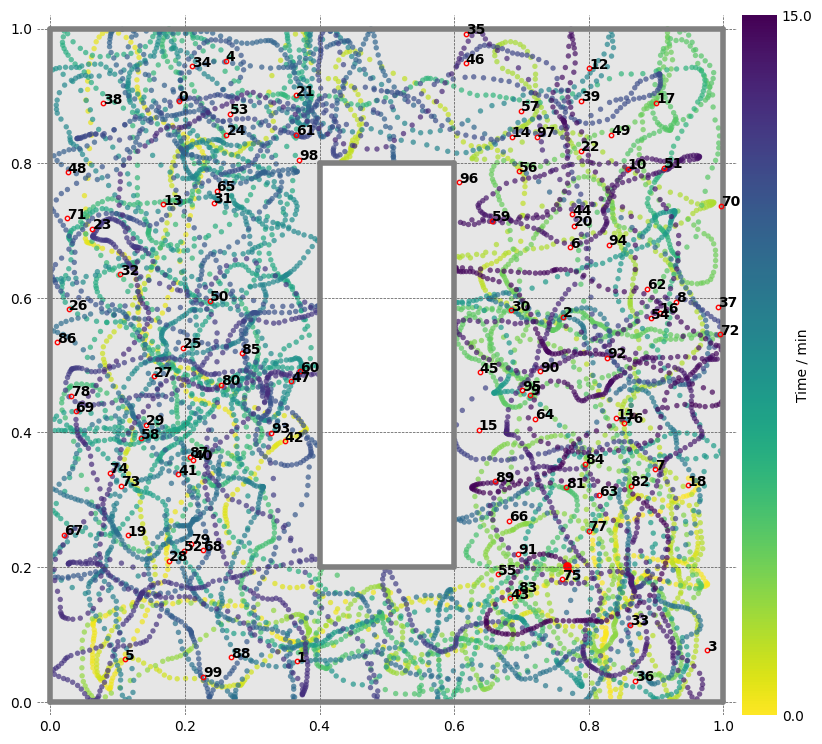

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
for i in range(NUM_OF_CUES):
    plt.annotate(text=i, xy=Env.objects['objects'][i], fontsize=10, fontweight='bold')
ax = Ag.plot_trajectory(color='changing', colorbar=True, gridlines=True,fig=fig, ax=ax, t_start=0, t_end=df['t'].max())

plt.show()

In [70]:
obj_names = [Env.objects['object_names'][i] for i in range(NUM_OF_CUES)]
obj_dist_cols = [f'dist_to_obj_{i}' for i in range(NUM_OF_CUES)]

# def get_position_text(x):

In [80]:
np.hstack(objects_encode_list[0:3]).reshape(1, 3, 3)

array([[[0.57000493, 0.88200647, 0.38490157],
        [0.70097844, 0.46329634, 0.33640087],
        [0.98186867, 0.06954147, 0.79551121]]])

## create positions

In [133]:
def apply_cps_to_positions(df, obj_dist_cols):
    dft = df[obj_dist_cols].T
    dft.columns = [f't_{i:08d}' for i in range(df.T.shape[1])]
    order = [int(val.split('_')[-1]) for val in dft.sort_values(dft.columns[0]).index[:MAX_NUMBER_OF_CUES]]
    # dft.sort_values(dft.columns[0])

    positions_list = []
    position_enc_list = []
    for feat in dft.columns:
        order = [int(val.split('_')[-1]) for val in dft.sort_values(feat).index[:MAX_NUMBER_OF_CUES]]
        positions_list.append(''.join([obj_names[i] for i in order]))
        position_enc_list.append(np.hstack([objects_encode_list[i] for i in order]))

    # len(positions_list)


    pos_state_dict = {'position_state':[val for val in positions_list],
                        'encode_position_state':[val for val in position_enc_list]}
    pos_state_df = pd.DataFrame(data=pos_state_dict, index=df.index)
    return pd.concat([df, pos_state_df], axis=1).copy()

In [84]:
df_ = apply_cps_to_positions(df, obj_dist_cols)
df_.shape

(18000, 408)

In [85]:
# dft = df[obj_dist_cols].T
# dft.columns = [f't_{i:08d}' for i in range(df.T.shape[1])]

In [87]:
# dft.columns[0]

In [88]:
# order = [int(val.split('_')[-1]) for val in dft.sort_values(dft.columns[0]).index[:MAX_NUMBER_OF_CUES]]
# dft.sort_values(dft.columns[0])

In [89]:
# order

In [90]:
# pos_text = ''.join([obj_names[i] for i in order])
# pos_text

In [91]:
# ap.head()

In [49]:
# Env.objects['object_names']

In [50]:
# positions_list = []
# for feat in dft.columns:
#     order = [int(val.split('_')[-1]) for val in dft.sort_values(feat).index[:MAX_NUMBER_OF_CUES]]
#     positions_list.append(''.join([obj_names[i] for i in order]))
# len(positions_list)

18000

In [ ]:
# pos_state_dict = {'position_state':[val for val in positions_list]}
# pos_state_df = pd.DataFrame(data=pos_state_dict, index=df.index)
# df = pd.concat([df, pos_state_df], axis=1)
# df.head(2)

,t,pos,distance_travelled,vel,rot_vel,head_direction,obj_0_pos,obj_0_name,obj_1_pos,obj_1_name,...,dist_to_obj_91,dist_to_obj_92,dist_to_obj_93,dist_to_obj_94,dist_to_obj_95,dist_to_obj_96,dist_to_obj_97,dist_to_obj_98,dist_to_obj_99,position_state
0,0.05,"[0.6230021379344022, 0.7234498345304414]",0.003526,"[-0.06925338508725343, -0.013348405018405174]",1.856510,"[-0.9917527122282292, -0.12816613354529732]","[0.6684926646805568, 0.2307395487112498]",LXVJ,"[0.7658613141747251, 0.7528009517926837]",KDSE,...,0.03385,0.698896,0.328994,0.744652,0.286967,0.534971,0.421117,0.607001,0.769387,NXHTVHKWIRUGPXQFMDKBRYHPKDSE
1,0.10,"[0.6210661210347255, 0.7226121604039898]",0.005636,"[-0.03872033799353414, -0.016753482529032748]",4.359029,"[-0.9755632025639372, -0.2197189973652584]","[0.6684926646805568, 0.2307395487112498]",LXVJ,"[0.7658613141747251, 0.7528009517926837]",KDSE,...,0.03508,0.699211,0.331082,0.744469,0.285808,0.534994,0.421002,0.606154,0.767443,NXHTVHKWIRUGPXQFMDKBRYHPKDSE


In [190]:
dfp = apply_cps_to_positions(df, obj_dist_cols)
dfp.shape

(18000, 408)

In [191]:
len(dfp), dfp['position_state'].nunique()/len(dfp), dfp['position_state'].nunique()

(18000, 0.2752777777777778, 4955)

In [192]:
num_unique_pos = dfp['position_state'].nunique()
num_unique_pos

4955

In [193]:
dfp['position_state_id'] = (dfp.groupby('position_state').transform('ngroup'))
dfp['normalized_position_state_id']  = (dfp['position_state_id'] / num_unique_pos)
dfp[['position_state_id', 'normalized_position_state_id']].sample(5)

,position_state_id,normalized_position_state_id
8396,1272,0.256710
17371,3593,0.725126
1086,4688,0.946115
14269,2739,0.552775
10535,1738,0.350757


In [194]:
dfp.shape

(18000, 410)

In [195]:
dfp[['position_state', 'position_state_id', 'normalized_position_state_id', 'encode_position_state']].iloc[8:12]

,position_state,position_state_id,normalized_position_state_id,encode_position_state
8,JUSISZHZYBKOLQVLLOCAAJECMBKL,2043,0.412311,"[[0.7586346079698574, 0.7805411603419811, 0.05..."
9,JUSISZHZYBKOLQVLLOCAAJECMBKL,2043,0.412311,"[[0.7586346079698574, 0.7805411603419811, 0.05..."
10,JUSISZHZYBKOLOCALQVLAJECMBKL,2035,0.410696,"[[0.7586346079698574, 0.7805411603419811, 0.05..."
11,JUSISZHZYBKOLOCALQVLAJECMBKL,2035,0.410696,"[[0.7586346079698574, 0.7805411603419811, 0.05..."


In [181]:
# help(Ag.plot_trajectory)

## get change of pos

In [196]:
dfp['last_position_state_id'] = (dfp['position_state_id'].shift(1))
dfp.shape

(18000, 411)

In [197]:
dfp[['position_state', 'position_state_id', 'last_position_state_id', 'encode_position_state']].iloc[8:12]

,position_state,position_state_id,last_position_state_id,encode_position_state
8,JUSISZHZYBKOLQVLLOCAAJECMBKL,2043,2043.0,"[[0.7586346079698574, 0.7805411603419811, 0.05..."
9,JUSISZHZYBKOLQVLLOCAAJECMBKL,2043,2043.0,"[[0.7586346079698574, 0.7805411603419811, 0.05..."
10,JUSISZHZYBKOLOCALQVLAJECMBKL,2035,2043.0,"[[0.7586346079698574, 0.7805411603419811, 0.05..."
11,JUSISZHZYBKOLOCALQVLAJECMBKL,2035,2035.0,"[[0.7586346079698574, 0.7805411603419811, 0.05..."


In [198]:
dfp[['position_state_id', 'last_position_state_id']].dtypes

position_state_id           int64
last_position_state_id    float64
dtype: object

In [199]:
dfp.shape

(18000, 411)

In [200]:
len(dfp['position_state_id'])

18000

In [201]:
change_dict_ = {'change_of_position_state':[int(pos!=last_pos) for pos, last_pos in zip(dfp['position_state_id'].astype('float'), dfp['last_position_state_id'])]}
change_dict_df = pd.DataFrame(change_dict_)

print(change_dict_df.shape)
# dfp = pd.concat([dfp, change_dict_df], ignore_index=True, axis=0)

(18000, 1)


In [203]:
dfp.shape

(18000, 411)

In [204]:
dfp['change_of_position_state'] = (change_dict_df['change_of_position_state'])

In [206]:
dfp.shape

(18000, 412)

In [207]:
# dfp['change_of_position_state'].values

array([1, 0, 0, ..., 0, 0, 0])

In [208]:
dfp[['position_state', 'position_state_id', 'last_position_state_id', 'change_of_position_state']].iloc[8:12]

,position_state,position_state_id,last_position_state_id,change_of_position_state
8,JUSISZHZYBKOLQVLLOCAAJECMBKL,2043,2043.0,0
9,JUSISZHZYBKOLQVLLOCAAJECMBKL,2043,2043.0,0
10,JUSISZHZYBKOLOCALQVLAJECMBKL,2035,2043.0,1
11,JUSISZHZYBKOLOCALQVLAJECMBKL,2035,2035.0,0


In [210]:
dfp[dfp['change_of_position_state'] == 1][['position_state_id', 'last_position_state_id', 'change_of_position_state']].head()

,position_state_id,last_position_state_id,change_of_position_state
0,2043,NaN,1
10,2035,2043.0,1
12,2034,2035.0,1
15,2036,2034.0,1
19,2037,2036.0,1


In [211]:
dfp[dfp['change_of_position_state'] == 1].shape

(8690, 412)

In [212]:
dfp['change_of_position_state'].mean()

0.48277777777777775

# train df

In [216]:
dfc = dfp[dfp['change_of_position_state'] == 1].reset_index(drop=True).copy()
dfc.shape

(8690, 412)

In [217]:
dfc['encode_position_state'].shape

(8690,)

In [218]:
dfc['encode_position_state'].values[0]

array([[0.75863461, 0.78054116, 0.05602303, 0.7335959 , 0.12314067,
        0.63546941, 0.36866625],
       [0.66480173, 0.15571297, 0.21781781, 0.09130913, 0.67851338,
        0.55055646, 0.95683741],
       [0.04364393, 0.72334149, 0.59089565, 0.80022703, 0.45734207,
        0.75452582, 0.75414852]])

In [219]:
dfc['encode_position_state'].values[0].shape

(3, 7)

In [268]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the Axes size
    and the *dpi* of the figure. This can lead to aliasing artifacts when
    the image is resampled because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled via the *interpolation* parameter
    and/or 

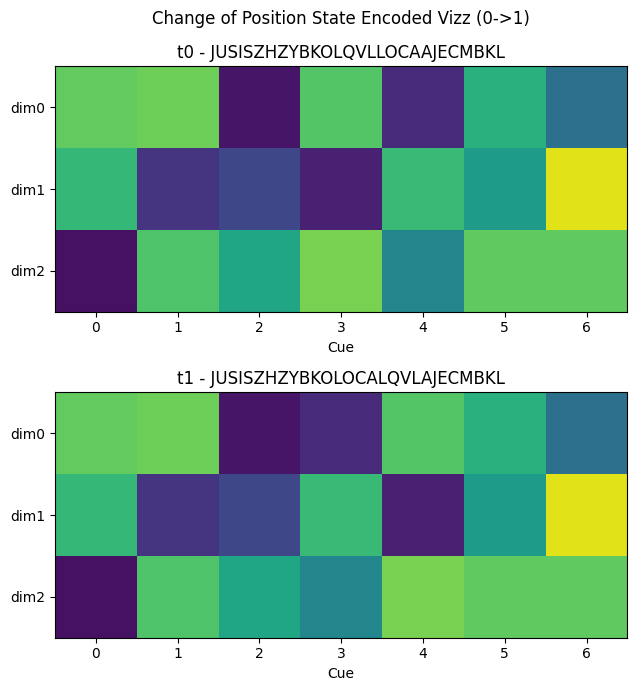

In [269]:
fig, ax = plt.subplots(2, 1, figsize=(16, 7))

t0 = 0
t1 = 1

plt.suptitle(f'Change of Position State Encoded Vizz ({t0}->{t1})')
p1 = ax[0].imshow(dfc['encode_position_state'].values[t0],vmin=0, vmax=1)
# plt.colorbar(p1, ax=ax[1])
p2 = ax[1].imshow(dfc['encode_position_state'].values[t1],vmin=0, vmax=1)
# plt.colorbar(p2, ax=ax[1])
ax[0].set_title(f't{t0} - {dfc["position_state"].values[t0]}',)
ax[1].set_title(f't{t1} - {dfc["position_state"].values[t1]}',)


ax[0].set_yticks([0, 1, 2])
ax[0].set_yticklabels(['dim0', 'dim1', 'dim2'])
ax[0].set_xlabel('Cue')

ax[1].set_yticks([0, 1, 2])
ax[1].set_yticklabels(['dim0', 'dim1', 'dim2'])
ax[1].set_xlabel('Cue')
# ax[0].set_()
plt.tight_layout()
plt.show()

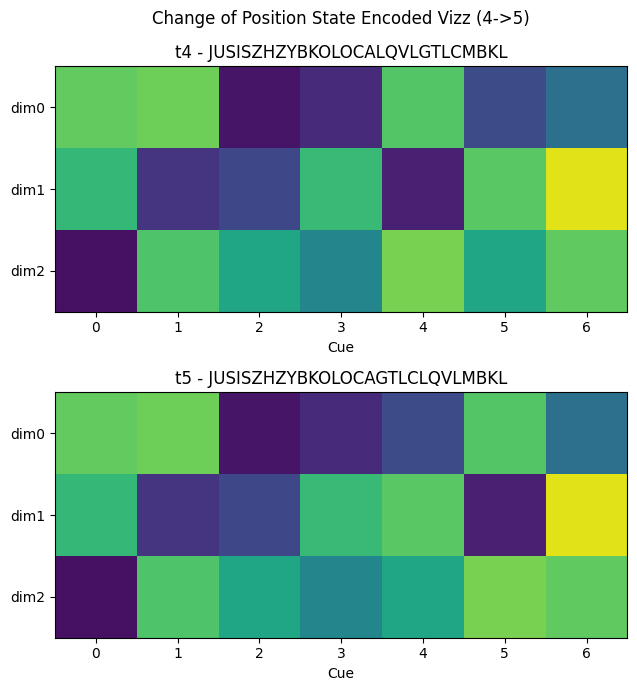

In [270]:
fig, ax = plt.subplots(2, 1, figsize=(16, 7))

t0 = 4
t1 = 5

plt.suptitle(f'Change of Position State Encoded Vizz ({t0}->{t1})')
p1 = ax[0].imshow(dfc['encode_position_state'].values[t0],vmin=0, vmax=1)
# plt.colorbar(p1, ax=ax[1])
p2 = ax[1].imshow(dfc['encode_position_state'].values[t1],vmin=0, vmax=1)
# plt.colorbar(p2, ax=ax[1])
ax[0].set_title(f't{t0} - {dfc["position_state"].values[t0]}',)
ax[1].set_title(f't{t1} - {dfc["position_state"].values[t1]}',)


ax[0].set_yticks([0, 1, 2])
ax[0].set_yticklabels(['dim0', 'dim1', 'dim2'])
ax[0].set_xlabel('Cue')

ax[1].set_yticks([0, 1, 2])
ax[1].set_yticklabels(['dim0', 'dim1', 'dim2'])
ax[1].set_xlabel('Cue')
# ax[0].set_()
plt.tight_layout()
plt.show()

In [271]:
dfc.head(2)

,t,pos,distance_travelled,vel,rot_vel,head_direction,obj_0_pos,obj_0_name,obj_0_enc,obj_1_pos,...,dist_to_obj_96,dist_to_obj_97,dist_to_obj_98,dist_to_obj_99,position_state,encode_position_state,position_state_id,normalized_position_state_id,last_position_state_id,change_of_position_state
0,0.05,"[0.9481359873429684, 0.33197961175786933]",0.002769,"[0.05478942838579304, -0.008028506825109583]",-2.588245,"[0.998248480520846, -0.05916055390056853]","[0.19061501152391858, 0.8929896169270976]",FIZB,"[[0.5700049322169386], [0.7009784407054439], [...","[0.36593238993110766, 0.0597703141757594]",...,0.556167,0.554938,0.747275,0.779552,JUSISZHZYBKOLQVLLOCAAJECMBKL,"[[0.7586346079698574, 0.7805411603419811, 0.05...",2043,0.412311,NaN,1
1,0.55,"[0.9583626153133962, 0.31473816173083613]",0.029473,"[-0.037931302661557975, -0.04846669295025419]",-6.319246,"[-0.06967333450757067, -0.9975698604401579]","[0.19061501152391858, 0.8929896169270976]",FIZB,"[[0.5700049322169386], [0.7009784407054439], [...","[0.36593238993110766, 0.0597703141757594]",...,0.576065,0.574852,0.766135,0.782741,JUSISZHZYBKOLOCALQVLAJECMBKL,"[[0.7586346079698574, 0.7805411603419811, 0.05...",2035,0.410696,2043.0,1


In [272]:
dfc.columns

Index(['t', 'pos', 'distance_travelled', 'vel', 'rot_vel', 'head_direction',
       'obj_0_pos', 'obj_0_name', 'obj_0_enc', 'obj_1_pos',
       ...
       'dist_to_obj_96', 'dist_to_obj_97', 'dist_to_obj_98', 'dist_to_obj_99',
       'position_state', 'encode_position_state', 'position_state_id',
       'normalized_position_state_id', 'last_position_state_id',
       'change_of_position_state'],
      dtype='object', length=412)

In [273]:
columns_to_keep = [
    't',
    'pos',
    'distance_travelled',
    'vel',
    'rot_vel',
    'head_direction',
    'position_state',
    'encode_position_state',
    'position_state_id',
    'normalized_position_state_id',
    'last_position_state_id',
    'change_of_position_state',
]

In [275]:
print(dfc[columns_to_keep].shape)
dfc[columns_to_keep].to_csv(r'/home/mgteus/workspace/navitrans/df_trainset_v0.csv', index=False)

(8690, 12)


# FIM

## explode xpos and ypos

In [57]:
df['x_pos'] = (df['pos'].explode()[::2])
df['y_pos'] = (df['pos'].explode()[1::2])

In [55]:
df['y_pos'].max()

0.9999915713572776

In [56]:
# df['pos'].explode()[::2]

In [57]:
# df.to_csv(r'/home/mgteus/workspace/navitrans/results_100_objs.csv', index=False)

In [58]:
FIXED_OBJECT = 10

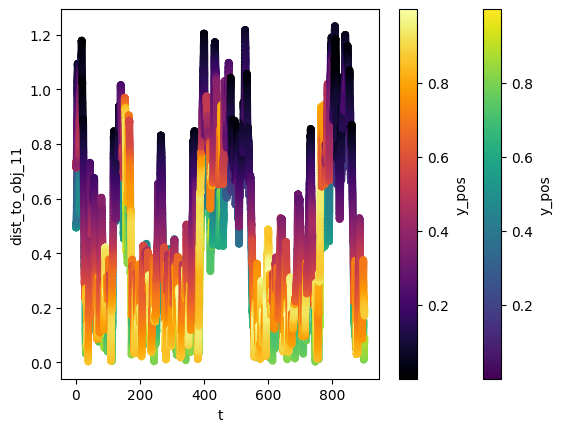

In [59]:
fig, ax = plt.subplots()
df.plot.scatter(x='t', y=f'dist_to_obj_{FIXED_OBJECT}', c='y_pos',ax=ax)
df.plot.scatter(x='t', y=f'dist_to_obj_{FIXED_OBJECT+1}', c='y_pos',ax=ax, cmap='inferno')
plt.show()

In [60]:

# df['last_position_state'] = df['position_state'].shift(1)

In [61]:
# df['change_of_state'] = int(df['position_state'].str == df['last_position_state'].str)

In [62]:
# df['change_of_state'].mean()

In [63]:
pd.set_option('display.max_colwidth', None)
df[['t', 'position_state', 'x_pos', 'y_pos']].iloc[50:55]

,t,position_state,x_pos,y_pos
50,2.55,ICTBNEQOIRZATWTOGPCQOGAKGRZQ,0.388353,0.353485
51,2.60,ICTBIRZANEQOTWTOGPCQOGAKGRZQ,0.387351,0.346321
52,2.65,IRZATWTONEQOICTBGPCQOGAKGRZQ,0.386919,0.341018
53,2.70,IRZATWTONEQOICTBGPCQOGAKGRZQ,0.385951,0.337239
54,2.75,IRZATWTONEQOICTBGPCQOGAKGRZQ,0.383549,0.331795
